In [5]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [6]:
#python -m spacy download en_core_web_sm
#Load spacy English language model

NER = spacy.load("en_core_web_sm") #Named Entity Recognition 

### Load the text we will be analyzing:
 "A Guide to Mythology" by Helen A. Clarke. This book is Public domain in the USA, and .txt file was pulled from github, found [here.](https://github.com/GITenberg/A-Guide-to-Mythology_67172)

In [7]:
import os

#Get the book file from the data directory where the .txt file is saved
book = [b for b in os.scandir('data') if '.txt' in b.name]

In [8]:
book

[<DirEntry '67172-0.txt'>, <DirEntry 'the_greek_myths.txt'>]

In [9]:
book_text = open(book[1], encoding='utf-8').read()
book_doc = NER(book_text)

In [10]:
#Visualize identified entities
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

In [11]:
#Read list of gods
gods_df = pd.read_csv('gods.csv')

In [12]:
gods_df = gods_df.drop(columns='Unnamed: 0')

In [13]:
gods_df.head()

,collection,god
0,Greek Olympians,Zeus
1,Greek Olympians,Athena
2,Greek Olympians,Poseidon
3,Greek Olympians,Aphrodite
4,Greek Olympians,Hermes


## Get name entity list per sentence

In [14]:
sent_entity_df = []

#Loop through sentences, store name entity list for each sentence
for sentence in book_doc.sents:
    entity_list = [ent.text for ent in sentence.ents]
    sent_entity_df.append({"sentence":sentence, "entities":entity_list })

sent_entity_df = pd.DataFrame(sent_entity_df)

In [15]:
sent_entity_df.head()

,sentence,entities
0,"( , THE, \n\n, GREEK, MYTHS, \n\n , THE, GREEK...","[GREEK, GREEK, HEROES, RETOLD\nROBIN WATERFIEL..."
1,"(New, York, •, London, \n, ©, 2012, by, Robin,...","[New York •, London, 2012, Robin Waterfield]"
2,"(No, part, of, this, book, may, be, reproduced...",[]
3,"(Scanning, ,, uploading, ,, and, electronic, \...",[]
4,"(Please, purchase, only, authorized, electroni...",[]


In [16]:
#Function to filer out non-character entities
def filter_entity(ent_list, gods_df):
    return [ent for ent in ent_list
        if ent in list(gods_df['god'])
        ]

In [17]:
filter_entity(['Zeus','Katherine','2'], gods_df) #testing cell

['Zeus']

In [18]:
#Creating a new column in the df 'character_entities'
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, gods_df))

#Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
8,"(For, Julian, ,, Kathy, ,, James, ,, and, Alex...","[Julian, Kathy, James, 1, The Population of th...","[Apollo, Artemis, Hermes]"
37,"(Each, \n, of, them, had, his, or, her, own, p...",[Aphrodite],[Aphrodite]
48,"(Now, ,, Prometheus, was, a, Titan, ,, one, of...","[Prometheus, Titan, Zeus, Olympians]","[Prometheus, Zeus]"
49,"(The, Titans, ,, led, by, Zeus, ’, father, Cro...","[Titans, Zeus, Cronus]","[Zeus, Cronus]"
50,"(Prometheus, ’, brothers, ,, \n, Menoetius, an...","[Menoetius, Atlas, Menoetius, Atlas, Titans]","[Atlas, Atlas]"
51,"(The, Titans, Atlas, and, Prometheus, ;, each,...","[The Titans Atlas and Prometheus, Zeus]",[Zeus]
52,"(But, Prometheus, had, persuaded, his, mother,...","[Themis, Zeus, Olympus]","[Themis, Zeus]"
58,"(So, Zeus, gave, the, job, of, equipping, the,...",[Zeus],[Zeus]
61,"(When, Prometheus, hesitated, ,, Epimetheus, s...","[Prometheus, Epimetheus]",[Prometheus]
75,"(And, Prometheus, was, pleasantly, surprised, .)",[Prometheus],[Prometheus]


## Create Relationships

In [19]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    god_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities),[])

    #Remove duplicated characters that are next to each other
    god_unique = [god_list[i] for i in range(len(god_list)) if (i==0) or god_list[i] != god_list[i-1]]

    if len(god_unique) > 1:
        for idx, a in enumerate(god_unique[:-1]):
            b = god_unique[idx + 1]
            relationships.append({'source':a, 'target':b})

In [20]:
relationships_df = pd.DataFrame(relationships)

In [21]:
relationships_df

,source,target
0,Apollo,Artemis
1,Artemis,Hermes
2,Apollo,Artemis
3,Artemis,Hermes
4,Apollo,Artemis
...,...,...
2561,Apollo,Hermes
2562,Apollo,Hermes
2563,Apollo,Hermes
2564,Apollo,Hermes


In [22]:
#Create a weight column to indicate how strong the relationship is (as appears in the text)
#Sort the cases with a -> b and b->a
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis =1), columns= relationships_df.columns)
relationships_df

,source,target
0,Apollo,Artemis
1,Artemis,Hermes
2,Apollo,Artemis
3,Artemis,Hermes
4,Apollo,Artemis
...,...,...
2561,Apollo,Hermes
2562,Apollo,Hermes
2563,Apollo,Hermes
2564,Apollo,Hermes


In [23]:
relationships_df['counts'] = relationships_df.groupby(['source','target'])['target'].transform('size')


In [24]:
relationships_df

,source,target,counts
0,Apollo,Artemis,94
1,Artemis,Hermes,24
2,Apollo,Artemis,94
3,Artemis,Hermes,24
4,Apollo,Artemis,94
...,...,...,...
2561,Apollo,Hermes,36
2562,Apollo,Hermes,36
2563,Apollo,Hermes,36
2564,Apollo,Hermes,36


In [25]:
relationships_df_sort = relationships_df.drop_duplicates().sort_values('counts',ascending=False)

In [26]:
relationships_df_sort.head()

,source,target,counts
360,Hera,Zeus,278
356,Athena,Zeus,159
199,Poseidon,Zeus,115
662,Hermes,Zeus,112
298,Apollo,Zeus,105


In [27]:
relationships_df_sort.reset_index(inplace=False, drop=True)

,source,target,counts
0,Hera,Zeus,278
1,Athena,Zeus,159
2,Poseidon,Zeus,115
3,Hermes,Zeus,112
4,Apollo,Zeus,105
...,...,...,...
109,Aphrodite,Poseidon,2
110,Cronus,Prometheus,2
111,Apollo,Atlas,2
112,Dionysus,Hestia,1


## Graph Analysis and Visualization

In [28]:
#Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationships_df_sort,
                            source= "source",
                            target= "target",
                            edge_attr= "counts",
                            create_using= nx.Graph())

### Graph visualization - Networkx

In [29]:
import scipy

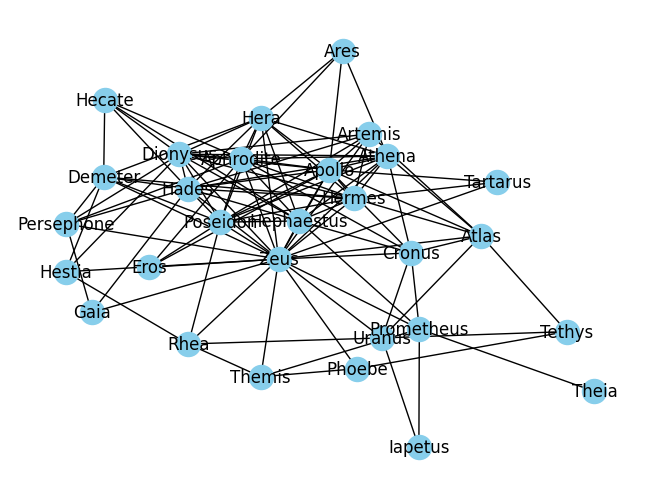

In [30]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

### Graph visualization - Pyvis

In [31]:
from pyvis.network import Network

net = Network(notebook=True, width="1000px",height="700px", bgcolor="#222222", font_color="white")

node_degree = dict(G.degree)
#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show('greek_gods.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## The most important characters in Greek Mythology

In [32]:
#Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict


{'Hera': 0.39285714285714285,
 'Zeus': 0.8214285714285714,
 'Athena': 0.42857142857142855,
 'Poseidon': 0.46428571428571425,
 'Hermes': 0.46428571428571425,
 'Apollo': 0.5357142857142857,
 'Artemis': 0.25,
 'Aphrodite': 0.46428571428571425,
 'Hades': 0.46428571428571425,
 'Hephaestus': 0.42857142857142855,
 'Prometheus': 0.21428571428571427,
 'Cronus': 0.2857142857142857,
 'Dionysus': 0.46428571428571425,
 'Atlas': 0.2857142857142857,
 'Demeter': 0.2857142857142857,
 'Themis': 0.14285714285714285,
 'Persephone': 0.21428571428571427,
 'Hestia': 0.14285714285714285,
 'Rhea': 0.17857142857142855,
 'Eros': 0.14285714285714285,
 'Hecate': 0.17857142857142855,
 'Uranus': 0.21428571428571427,
 'Gaia': 0.10714285714285714,
 'Tartarus': 0.10714285714285714,
 'Iapetus': 0.07142857142857142,
 'Phoebe': 0.10714285714285714,
 'Tethys': 0.10714285714285714,
 'Ares': 0.14285714285714285,
 'Theia': 0.03571428571428571}

<AxesSubplot: >

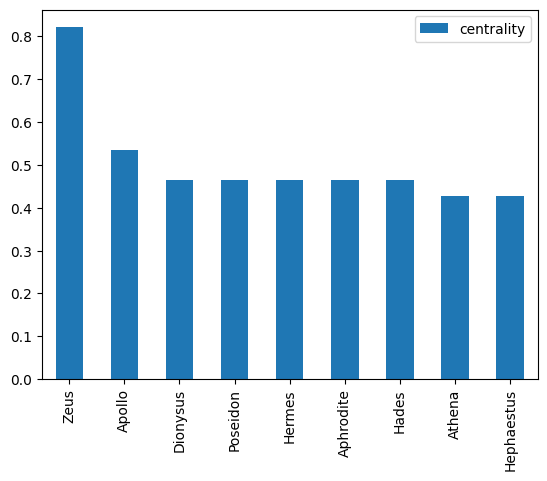

In [33]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
#Plot top 10 nodes
degree_df.sort_values('centrality',ascending=False)[0:9].plot(kind="bar")

<AxesSubplot: >

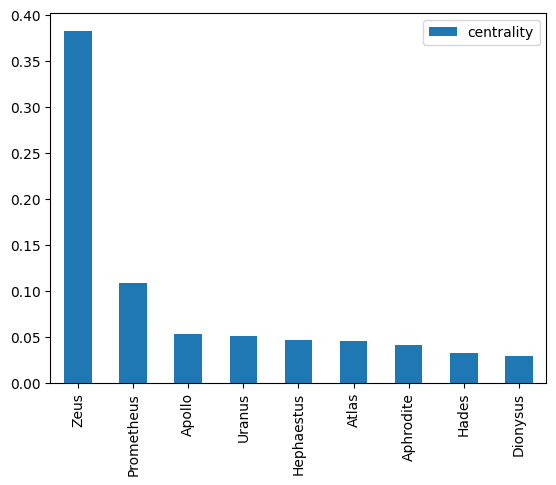

In [34]:
# Betweeness Centrality
between_dict = nx.betweenness_centrality(G)
between_dict
between_df = pd.DataFrame.from_dict(between_dict, orient='index', columns=['centrality'])
#Plot top 10 nodes
between_df.sort_values('centrality',ascending=False)[0:9].plot(kind="bar")

<AxesSubplot: >

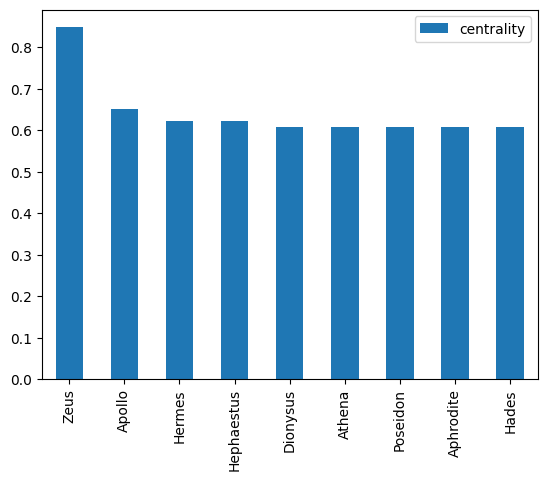

In [35]:
# Closeness Centrality
closeness_dict = nx.closeness_centrality(G)
closeness_dict
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
#Plot top 10 nodes
closeness_df.sort_values('centrality',ascending=False)[0:9].plot(kind="bar")

#Shows it's a very dense network

In [36]:
#Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, between_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Community Detection

In [3]:
import community.community_louvain as community_louvain

In [37]:
communities = community_louvain.best_partition(G)

In [38]:
communities

{'Hera': 0,
 'Zeus': 1,
 'Athena': 0,
 'Poseidon': 0,
 'Hermes': 0,
 'Apollo': 0,
 'Artemis': 0,
 'Aphrodite': 0,
 'Hades': 2,
 'Hephaestus': 0,
 'Prometheus': 1,
 'Cronus': 1,
 'Dionysus': 0,
 'Atlas': 1,
 'Demeter': 2,
 'Themis': 1,
 'Persephone': 2,
 'Hestia': 1,
 'Rhea': 1,
 'Eros': 0,
 'Hecate': 2,
 'Uranus': 1,
 'Gaia': 2,
 'Tartarus': 1,
 'Iapetus': 1,
 'Phoebe': 1,
 'Tethys': 1,
 'Ares': 0,
 'Theia': 1}

In [39]:
nx.set_node_attributes(G, communities, 'group')

In [40]:
com_net = Network(notebook =True, width = "1000px", height = "700px", bgcolor="#222222", font_color='white')
com_net.from_nx(G)
com_net.show("greek_gods.html")

#Maps different communities

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
